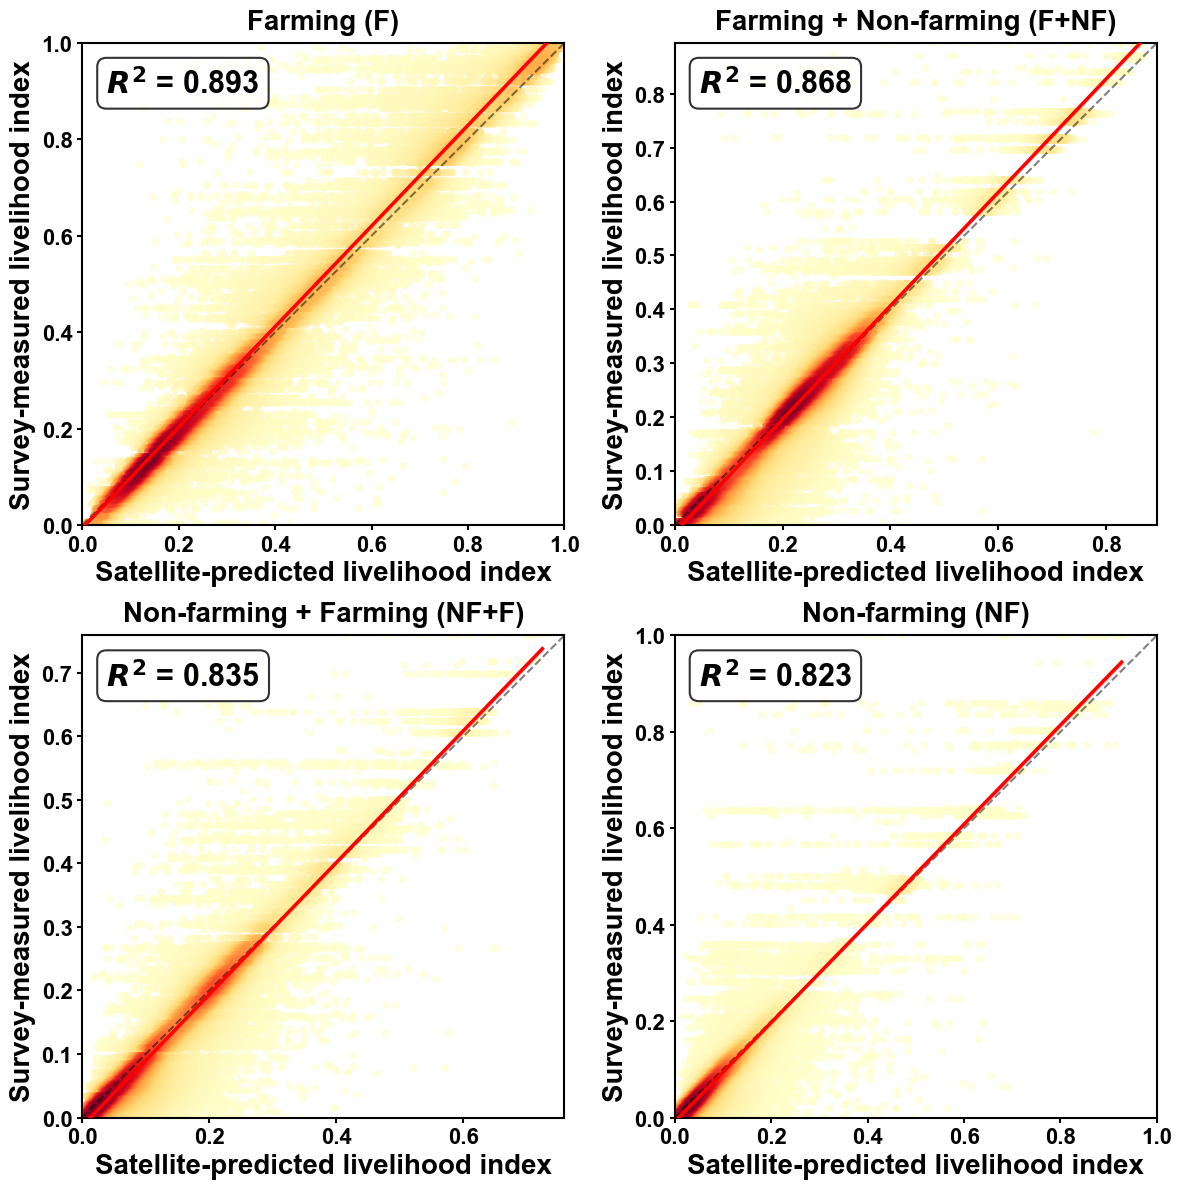

验证结果统计:

Farming (F):
  样本数: 29410
  R² = 0.8931
  RMSE = 0.0963
  斜率 = 1.0444
  截距 = -0.0064
  p值 = 0.0000e+00

Farming + Non-farming (F+NF):
  样本数: 29410
  R² = 0.8684
  RMSE = 0.0710
  斜率 = 1.0519
  截距 = -0.0141
  p值 = 0.0000e+00

Non-farming + Farming (NF+F):
  样本数: 29410
  R² = 0.8352
  RMSE = 0.0611
  斜率 = 1.0376
  截距 = -0.0135
  p值 = 0.0000e+00

Non-farming (NF):
  样本数: 29410
  R² = 0.8234
  RMSE = 0.0698
  斜率 = 1.0288
  截距 = -0.0089
  p值 = 0.0000e+00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
import seaborn as sns

# 设置全局字体
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

# 读取数据
df = pd.read_csv(r'F:\00.博后研究\城乡连续体制图\New_NEW\04.验证\00.村子所在验证（样本观测值与拟合值的散点）\村子尺度.csv')

# 定义配对关系
pairs = [
    ('F_Satellite', 'F_Survey'),
    ('F_NF_Satellite', 'F_NF_Survey'),
    ('NF_F_Satellite', 'NF_F_Survey'),
    ('NF_Satellite', 'NF_Survey')
]

# 子图标题
titles = ['Farming (F)', 'Farming + Non-farming (F+NF)', 
          'Non-farming + Farming (NF+F)', 'Non-farming (NF)']

# 创建2x2子图
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, (x_col, y_col) in enumerate(pairs):
    ax = axes[idx]
    
    # 提取数据并删除NaN
    x = df[x_col].values
    y = df[y_col].values
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    # 计算密度
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    # 按密度排序，使高密度点在上层
    idx_sort = np.argsort(z)
    x_sorted = x[idx_sort]
    y_sorted = y[idx_sort]
    z_sorted = z[idx_sort]
    
    # 绘制散点图（带密度颜色）
    scatter = ax.scatter(x_sorted, y_sorted, c=z_sorted, s=30, 
                        cmap='YlOrRd', alpha=0.6, edgecolors='none')
    
    # 线性拟合
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line_x = np.array([x.min(), x.max()])
    line_y = slope * line_x + intercept
    
    # 绘制拟合线
    ax.plot(line_x, line_y, color='red', linewidth=2.5, zorder=5)
    
    # 计算置信区间（95%）
    predict_y = slope * x + intercept
    residuals = y - predict_y
    residual_std = np.sqrt(np.sum(residuals**2) / (len(x) - 2))
    
    # 标准误差
    x_mean = np.mean(x)
    se = residual_std * np.sqrt(1/len(x) + (line_x - x_mean)**2 / np.sum((x - x_mean)**2))
    ci = 1.96 * se  # 95% 置信区间
    
    # 绘制置信区间
    ax.fill_between(line_x, line_y - ci, line_y + ci, 
                     color='red', alpha=0.2, zorder=3)
    
    # 计算R²
    r2 = r2_score(y, predict_y)
    
    # 添加R²标注（左上角）
    ax.text(0.05, 0.95, f'$R^2$ = {r2:.3f}', 
            transform=ax.transAxes, fontsize=22, fontweight='bold',
            verticalalignment='top', bbox=dict(boxstyle='round', 
            facecolor='white', alpha=0.8, edgecolor='black', linewidth=1.5))
    
    # 添加1:1参考线（虚线）
    lim_min = min(x.min(), y.min())
    lim_max = max(x.max(), y.max())
    ax.plot([lim_min, lim_max], [lim_min, lim_max], 
            'k--', linewidth=1.5, alpha=0.5, zorder=2)
    
    # 设置坐标轴标签
    ax.set_xlabel('Satellite-predicted livelihood index', 
                  fontsize=20, fontweight='bold', color='black')
    ax.set_ylabel('Survey-measured livelihood index', 
                  fontsize=20, fontweight='bold', color='black')
    
    # 设置子图标题
    ax.set_title(titles[idx], fontsize=20, fontweight='bold', 
                color='black', pad=10)
    
    # 设置刻度标签加粗
    ax.tick_params(axis='both', labelsize=16, width=1.5)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_color('black')
    
    # 设置坐标轴范围相同
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect('equal')
    
    # 加粗边框
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color('black')

# 调整子图间距
plt.tight_layout()

# 保存图片
plt.savefig(r'F:\00.博后研究\城乡连续体制图\New_NEW\04.验证\00.村子所在验证（样本观测值与拟合值的散点）\validation_scatter.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# 打印统计结果
print("=" * 60)
print("验证结果统计:")
print("=" * 60)
for idx, (x_col, y_col) in enumerate(pairs):
    x = df[x_col].dropna().values
    y = df[y_col].dropna().values
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    predict_y = slope * x + intercept
    r2 = r2_score(y, predict_y)
    rmse = np.sqrt(np.mean((y - predict_y)**2))
    
    print(f"\n{titles[idx]}:")
    print(f"  样本数: {len(x)}")
    print(f"  R² = {r2:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  斜率 = {slope:.4f}")
    print(f"  截距 = {intercept:.4f}")
    print(f"  p值 = {p_value:.4e}")